In [9]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [10]:
pathway_df = pd.read_csv('/homes/gws/psturm/pathways.tsv', sep='\t')
pathway_df.head()

,Genes,REACTOME_GLYCOGEN_BREAKDOWN_GLYCOGENOLYSIS,REACTOME_TRANSLATION,REACTOME_PYRIMIDINE_CATABOLISM,REACTOME_RNA_POL_III_TRANSCRIPTION_INITIATION_FROM_TYPE_2_PROMOTER,REACTOME_INHIBITION_OF_THE_PROTEOLYTIC_ACTIVITY_OF_APC_C_REQUIRED_FOR_THE_ONSET_OF_ANAPHASE_BY_MITOTIC_SPINDLE_CHECKPOINT_COMPONENTS,REACTOME_PYRUVATE_METABOLISM_AND_CITRIC_ACID_TCA_CYCLE,REACTOME_EXTRINSIC_PATHWAY_FOR_APOPTOSIS,REACTOME_PTM_GAMMA_CARBOXYLATION_HYPUSINE_FORMATION_AND_ARYLSULFATASE_ACTIVATION,REACTOME_APOPTOTIC_CLEAVAGE_OF_CELLULAR_PROTEINS,...,REACTOME_DIGESTION_OF_DIETARY_CARBOHYDRATE,REACTOME_FGFR1_LIGAND_BINDING_AND_ACTIVATION,REACTOME_GAP_JUNCTION_ASSEMBLY,REACTOME_SYNTHESIS_OF_GLYCOSYLPHOSPHATIDYLINOSITOL_GPI,REACTOME_RNA_POL_I_TRANSCRIPTION_INITIATION,REACTOME_PYRIMIDINE_METABOLISM,REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS,REACTOME_PI3K_CASCADE,REACTOME_APOPTOTIC_EXECUTION_PHASE,REACTOME_SHC_RELATED_EVENTS
0,A1BG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A1CF,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A2LD1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A2M,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A2ML1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
pathway_df.shape

(16864, 675)

In [12]:
pathwayMat = pathway_df.drop('Genes', axis=1).values

Number of genes in each pathway:
Average:	47.61275964391692
Deviation:	72.10316473901405
[min, 25%, med, 75%, max] = [  4.    14.    24.5   50.75 819.  ]


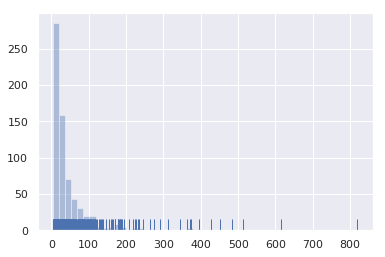

In [13]:
numGenesInEachPathway = np.sum(pathwayMat, axis=0)
numPathwaysEachGene   = np.sum(pathwayMat, axis=1)

print("Number of genes in each pathway:")
print("Average:\t{}".format(np.mean(numGenesInEachPathway)))
print("Deviation:\t{}".format(np.std(numGenesInEachPathway)))
print("[min, 25%, med, 75%, max] = {}".format(np.percentile(numGenesInEachPathway, [0, 25, 50, 75, 100])))
sns.distplot(numGenesInEachPathway, kde=False, rug=True)

Number of pathways each gene belongs to:
Average:	1.9029293168880455
Deviation:	4.975402585499316
[min, 25%, med, 75%, max] = [  0.   0.   0.   2. 111.]


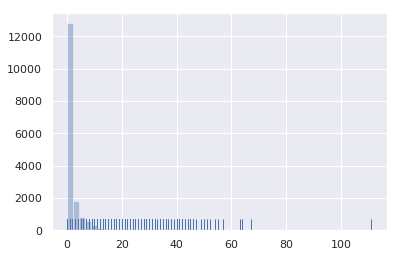

In [14]:
print("Number of pathways each gene belongs to:")
print("Average:\t{}".format(np.mean(numPathwaysEachGene)))
print("Deviation:\t{}".format(np.std(numPathwaysEachGene)))
print("[min, 25%, med, 75%, max] = {}".format(np.percentile(numPathwaysEachGene, [0, 25, 50, 75, 100])))
sns.distplot(numPathwaysEachGene, kde=False, rug=True)

Number of pathways each gene belongs to after removing zeros:
Average:	6.288653733098178
Deviation:	7.363890867126464
[min, 25%, med, 75%, max] = [  1.   3.   4.   7. 111.]


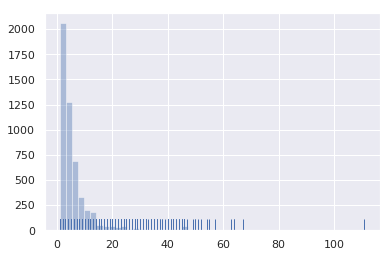

In [15]:
np.sum(numPathwaysEachGene == 0)
nonZeroNumPathwaysEachGene = numPathwaysEachGene[numPathwaysEachGene > 0]
print("Number of pathways each gene belongs to after removing zeros:")
print("Average:\t{}".format(np.mean(nonZeroNumPathwaysEachGene)))
print("Deviation:\t{}".format(np.std(nonZeroNumPathwaysEachGene)))
print("[min, 25%, med, 75%, max] = {}".format(np.percentile(nonZeroNumPathwaysEachGene, [0, 25, 50, 75, 100])))
sns.distplot(nonZeroNumPathwaysEachGene, kde=False, rug=True)

In [16]:
nonzero_df = pathway_df[pathway_df.drop('Genes', axis=1).sum(axis=1) > 0]
nonzero_df.shape

(5103, 675)

In [17]:
nonzeroMat  = nonzero_df.drop('Genes', axis=1).values.astype(np.float32)
geneGeneMat = np.dot(nonzeroMat, nonzeroMat.T)
geneGeneMat.shape

(5103, 5103)

In [30]:
def GetNeighborDictionary(binaryPathwayMatrix, percentileThreshold=90):
    neighbors = {}

    nonzeroIndices = np.where(np.any(binaryPathwayMatrix, axis=1))[0]
    nonzeroPathwayMat = binaryPathwayMatrix[nonzeroIndices, :]
    numNonzero, k = nonzeroPathwayMat.shape

    geneDegreeMatrix  = np.dot(nonzeroPathwayMat, nonzeroPathwayMat.T)
    np.fill_diagonal(geneDegreeMatrix, 0.0)
    
    degreePercentiles = np.percentile(geneDegreeMatrix, percentileThreshold, axis=1)
    geneDegreeMatrix[geneDegreeMatrix <= np.expand_dims(degreePercentiles, axis=1)] = 0
    
    geneDegreeCounts  = np.sum(geneDegreeMatrix, axis=1)

    for i in range(numNonzero):
        geneDegree = geneDegreeCounts[i]
        if (geneDegree == 0):
            continue

        neighbors[nonzeroIndices[i]] = []
        neighborEdgeIndices = geneDegreeMatrix[i, :].nonzero()[0]
        neighborEdgeWeights = geneDegreeMatrix[i, neighborEdgeIndices]
        for j in range(len(neighborEdgeIndices)):
            neighbors[nonzeroIndices[i]].append([
                nonzeroIndices[neighborEdgeIndices[j]],
                neighborEdgeWeights[j] / geneDegree
            ])
    
    return neighbors

In [33]:
neighbors = GetNeighborDictionary(geneGeneMat, 95)

In [38]:
i = 0
for key, value in neighbors.items():
    i = i + 1
    print('{}: {}'.format(key, len(value)))
    if i > 100:
        break

2: 26
83: 36
95: 38
102: 38
103: 38
104: 38
105: 38
106: 38
107: 38
108: 38
109: 38
132: 37
133: 17
137: 38
141: 38
174: 37
175: 36
176: 38
177: 38
219: 38
220: 38
222: 38
223: 38
224: 38
234: 6
235: 6
236: 6
237: 6
238: 6
239: 6
240: 36
241: 36
242: 36
243: 38
244: 36
254: 5
255: 5
266: 38
283: 6
315: 38
316: 38
325: 1
361: 38
362: 38
445: 6
459: 5
460: 5
461: 5
462: 5
463: 5
464: 5
468: 38
516: 37
528: 38
530: 15
531: 15
593: 38
594: 38
595: 38
596: 2
598: 2
599: 2
600: 2
601: 38
604: 2
622: 38
626: 38
653: 38
654: 38
655: 35
657: 18
661: 6
662: 4
663: 34
665: 2
666: 2
669: 1
672: 1
673: 1
694: 29
696: 26
701: 5
702: 5
703: 5
704: 29
728: 38
729: 38
730: 38
731: 18
734: 38
738: 38
739: 38
740: 38
741: 22
759: 38
761: 38
767: 34
768: 18
769: 2
770: 38
771: 38


Number of neighbors for each gene
Average:	479.49481201171875
Deviation:	371.3160095214844
[min, 25%, med, 75%, max] = [   7.  207.  395.  614. 2902.]


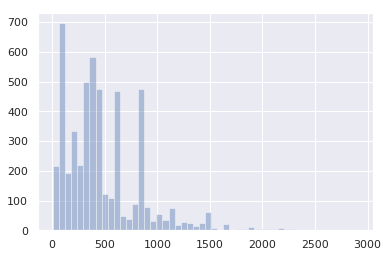

In [30]:
np.fill_diagonal(geneGeneMat, 0.0) #To only count gene-gene interactions between two different genes
binaryMat = (geneGeneMat > 0.0).astype(np.float32)

numNeighborsEachGene = np.sum(binaryMat, axis=0)
print("Number of neighbors for each gene")
print("Average:\t{}".format(np.mean(numNeighborsEachGene)))
print("Deviation:\t{}".format(np.std(numNeighborsEachGene)))
print("[min, 25%, med, 75%, max] = {}".format(np.percentile(numNeighborsEachGene, [0, 25, 50, 75, 100])))
sns.distplot(numNeighborsEachGene, kde=False)

Number of neighbors for each gene
Average:	979.79345703125
Deviation:	1007.5249633789062
[min, 25%, med, 75%, max] = [7.000e+00 3.110e+02 6.900e+02 1.306e+03 9.714e+03]


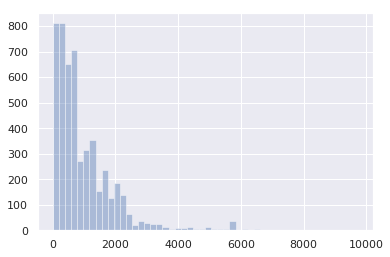

In [37]:
averageGeneConnectivity = np.sum(geneGeneMat, axis=0)
print("Number of neighbors for each gene")
print("Average:\t{}".format(np.mean(averageGeneConnectivity)))
print("Deviation:\t{}".format(np.std(averageGeneConnectivity)))
print("[min, 25%, med, 75%, max] = {}".format(np.percentile(averageGeneConnectivity, [0, 25, 50, 75, 100])))
sns.distplot(averageGeneConnectivity, kde=False)